In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import scipy as sp
import scipy.optimize
from sklearn import preprocessing

import utility_functions as fn

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Initialization

In [2]:
# read from csv into a new dataframe
raw_weather = pd.read_csv('weather_raw2.csv',index_col=1)

# reindex by appropriate datetime
raw_weather.index = pd.to_datetime(raw_weather.index,format='%Y-%m-%d %H:00:00 +0000 UTC')
raw_weather.index.names = ['']

# remove unused columns
raw_weather.drop(raw_weather.columns[np.array([0,1,2,3,4,9,10,13,15,16,17,19,20,21,23,24,25,26])],axis=1,inplace=True)

# rename and reorder columns
column_names = ['temp','tmin','tmax','pressure','humidity','wind','rain','snow','clouds']
raw_weather.columns = column_names
raw_weather = raw_weather[['temp','tmin','tmax','pressure','humidity','wind','clouds','rain','snow']]

In [3]:
# drop duplicate rows
raw_weather.drop_duplicates(inplace=True)

# reindex to add missing rows, for a total length of 53545
correct_dt = pd.DatetimeIndex(start='2013-01-01 00:00:00',end='2019-02-10 00:00:00',freq='h')
raw_weather = raw_weather.reindex(index=correct_dt)

In [4]:
print(raw_weather.isnull().sum())
# fn.plot_all(raw_weather,'2013-01-02 00:00:00','2019-02-09 00:00:00')

temp         1129
tmin         1129
tmax         1129
pressure     1129
humidity     1129
wind         1129
clouds       1129
rain        49699
snow        53440
dtype: int64


# Error Identification

In [5]:
# set violating values to NaN based on hardcoded low and high limit values for each column separately
sparse_weather = raw_weather.copy(deep=True)

low_tuners = [250,240,250,900,5,0,0,0,0]
high_tuners = [350,350,350,1100,100,25,100,100,10]
j=0

for i in raw_weather.columns:
    sparse_weather[i].where(sparse_weather[i] >= low_tuners[j],inplace=True)
    sparse_weather[i].where(sparse_weather[i] <= high_tuners[j],inplace=True)
    j=j+1

In [6]:
# assign NaN precip values to zero, this is an unconfirmed assumption
sparse_weather['rain'].replace(np.NaN,0,inplace=True)
sparse_weather['snow'].replace(np.NaN,0,inplace=True)

# set initial humidity value to suppress errors
sparse_weather['humidity'][0] = 46

In [7]:
# fn.plot_all(sparse_weather,'2013-01-01 00:00:00','2019-02-10 00:00:00')
print(sparse_weather.isnull().sum())

temp        1136
tmin        1136
tmax        1136
pressure    1521
humidity    2160
wind        1133
clouds      1129
rain           0
snow           0
dtype: int64


# Imputation

In [8]:
# impute missing ranges shorter than 6 hours using linear interpolation
dense_weather = sparse_weather.copy(deep=True)
impute_ok = fn.gap_indicator(dense_weather,6)

for i in dense_weather.columns:
    dense_weather[i].mask(impute_ok[i]==True,dense_weather[i].interpolate(method='linear',limit=6),inplace=True)


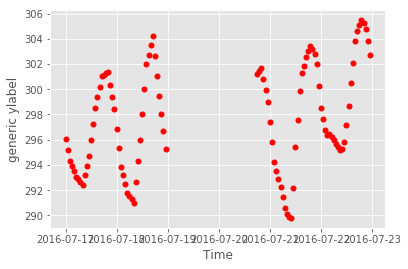

In [9]:
fn.plot_feature(dense_weather,'temp','2016-07-17 00:00:00','2016-07-23 00:00:00')
# print(dense_weather.isnull().sum())

In [14]:
# impute large segments using least-squares optimization of a sinusoidal curve


# returns index labels where nan values appear for a certain column
false_index = impute_ok['temp'].index[impute_ok['temp'].apply(np.logical_not)]
print(false_index)

# gap checker function

print('start | end')
    
for i in range(len(df)):
    if (df['temp'][i-1]==True) & (df[gap_indicator_column][i]==False):
        gap_start=i
        for j in range(i,len(df)):
            if df[gap_indicator_column][j]==True:
                gap_end=j
                break
        print(gap_start, gap_end)



DatetimeIndex(['2013-10-21 14:00:00', '2013-10-21 15:00:00',
               '2013-10-21 16:00:00', '2013-10-21 17:00:00',
               '2013-10-21 18:00:00', '2013-10-21 19:00:00',
               '2013-10-21 20:00:00', '2013-10-21 21:00:00',
               '2013-10-21 22:00:00', '2013-10-21 23:00:00',
               ...
               '2016-07-20 08:00:00', '2016-07-20 09:00:00',
               '2016-07-20 10:00:00', '2016-07-20 11:00:00',
               '2016-07-20 12:00:00', '2016-07-20 13:00:00',
               '2016-07-20 14:00:00', '2016-07-20 15:00:00',
               '2016-07-20 16:00:00', '2016-07-20 17:00:00'],
              dtype='datetime64[ns]', length=154, freq=None)


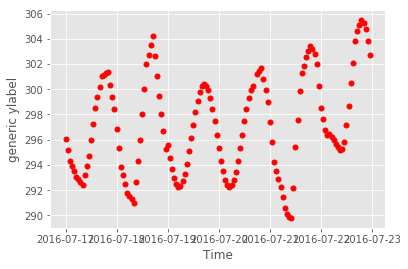

In [11]:
# assigning gap indices manually for now, use impute_ok later on
gap_start = dense_weather.index.get_loc('2016-07-19 00:00:00')
gap_end = dense_weather.index.get_loc('2016-07-20 17:00:00')
gap_length = gap_end - gap_start

# could calculate this as gap_start - (gap_length*2,3)
impute_start = dense_weather.index.get_loc('2016-07-10 00:00:00')

# subset dense_weather to the values just before the gap
impute_data = dense_weather.iloc[impute_start:gap_start]
impute_data.index = np.arange(len(impute_data))

fit = fn.fit_sin(impute_data.index,impute_data['temp'])

dense_weather.iloc[gap_start:gap_end,[0]] = pd.DataFrame(fit['fitfunc'](np.arange(len(impute_data),len(impute_data)+gap_length,1))).values

fn.plot_feature(dense_weather,'temp','2016-07-17 00:00:00','2016-07-23 00:00:00')

# Additional Features & Scaling

In [12]:
# this function adds columns with data from previous hours associated with the target hour
hours_before = np.arange(16,25)
weather_with_previous = fn.add_hours_before(weather,hours_before)
weather_with_previous.describe()

NameError: name 'weather' is not defined

In [ ]:
# implements sklearn MinMaxScaler
x = weather_with_previous.values
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(x)

scaled = pd.DataFrame(x_scaled)
scaled.columns = weather_with_previous.columns
scaled.index = weather_with_previous.index

scaled.describe()

In [ ]:
# scaled.to_csv('weather_clean.csv')

# unused code below

In [ ]:
# # returns index labels where nan values appear for a certain column
# nan_index = weather['temp'].index[weather['temp'].apply(np.isnan)]
# nan_index

# correct and complete datetime index for the date range considered
# dt = pd.DatetimeIndex(start='2013-01-01 00:00:00',end='2019-02-10 00:00:00',freq='h')

# # renames (here, makes lowercase) column labels using a simple loop
# df.columns = [x.lower() for x in df.columns]

# # implements sklearn scaler
# from sklearn import preprocessing
# x = df.values #returns a numpy array
# scaler = preprocessing.MinMaxScaler()
# x_scaled = scaler.fit_transform(x)
# df = pandas.DataFrame(x_scaled)

In [ ]:
# code from when i was adding an 'impute_ok' column

# TEMPORARY bypass missing 2014-2015 data
# weather = raw_weather.truncate('2016-01-01 00:00:00','2019-02-10 00:00:00')
# weather = raw_weather.copy(deep=False)

# add an 'impute_ok' column; True if time gap is less than 6 hours
# orig_len = len(raw_weather.index)
# raw_weather.insert(0,'impute_ok',True)
# raw_weather['impute_ok'].iloc[1:orig_len]=(raw_weather.index[1:orig_len]-raw_weather.index[0:orig_len-1] <= '06:00:00')